In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import time
from datetime import datetime
from datetime import date, timedelta
import plotly
from chart_studio import plotly
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
observation_date = datetime(2019, 11, 1).date() # момент анализа 
horizon_days = 14 #горизонт анализа

## **Описание проекта**

In [5]:
try:
    visits, orders, costs = (
    pd.read_csv('D:/datasets/visits_info_short.csv'),
    pd.read_csv('D:/datasets/orders_info_short.csv'),  
    pd.read_csv('D:/datasets/costs_info_short.csv')  
)
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")    

         Структура visits_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

         Структура orders_info_short.csv
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

         Структура costs_info_short.csv
- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

## **Предобработка данных**

### Работа с **visits** (лог сервера с информацией о посещениях сайта)

In [6]:
visits.info()
visits.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

- Пропуски отсутсвуют, приведем названия к нижнему регистру и уберем пробелы.

In [7]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]

**Приведем начало и конец сессий к формату даты**

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

- Проверим данные на уникальные значения, для изучения возможных аномалий и выбросов:

**Видим, что один пользователь посещал сайт аж 46 раз**

In [9]:
visits['user_id'].value_counts()

33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

**Работу будем вести с 4 регионами: `US`, `UK`, `France`, `Germany`.**

In [10]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

**Видим, что пользователи используют 2 мобильные системы: `Iphone` и `Android`, и 2 стационарные системы `Mac` и `PC`**

In [11]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

**Видим много каналов привлечения, приведем их к нижнему регистру**

In [12]:
visits['channel'] = visits['channel'].str.lower()
visits['channel'].unique()

array(['organic', 'tiptop', 'rocketsuperads', 'yrabbit', 'faceboom',
       'mediatornado', 'adnonsense', 'leapbob', 'wahoonetbanner',
       'opplecreativemedia', 'lambdamediaads'], dtype=object)

**309 901 сессий успешно начались и завершились**

In [13]:
visits['user_id'].count()

visits['session_start'].count()

visits['session_end'].count()

309901

### Работа с **orders** (информация о заказах)

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [15]:
orders.rename(columns = {'User Id':'user_id',
                         'Event Dt':'event_dt',
                         'Revenue':'revenue'}, inplace=True)

In [16]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

**Можно заметить, что один пользователь совершил 22 покупки**

In [17]:
orders['user_id'].value_counts()

901180916748    22
883098437811    20
75337957494     19
512471511263    19
295795879965    19
                ..
237296010927     1
319939546352     1
742075710598     1
202972423389     1
775233404832     1
Name: user_id, Length: 8881, dtype: int64

**Проверим, не было ли пустых покупок**

In [18]:
orders['revenue'].value_counts()

4.99     38631
5.99       780
9.99       385
49.99      212
19.99      204
Name: revenue, dtype: int64

**Средняя сумма покупки на значении: 5.37 , медиана равна 4.99, все квартили равны 4.99.**

**Можно сказать, что стандартная подписка приложения равна 4.99**

In [19]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [20]:
orders['event_dt'].count()

40212

### Работа с **costs** (информация о затратах на маркетинг

In [21]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [22]:
costs.columns = map(str.lower, costs.columns)

In [23]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [24]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Приведем строки каналов привлечения к нижнему регистру.**

In [25]:
costs['channel'] = costs['channel'].str.lower()

**Видим знакомые каналы привлечения**

In [26]:
costs['channel'].unique()

array(['faceboom', 'mediatornado', 'rocketsuperads', 'tiptop', 'yrabbit',
       'adnonsense', 'leapbob', 'opplecreativemedia', 'wahoonetbanner',
       'lambdamediaads'], dtype=object)

**Здесь видим, что затраты на привлечение новых клиентов была в течении 180 дней, что равно с логом сервера**

In [27]:
costs['dt'].value_counts()

2019-10-10    10
2019-06-01    10
2019-08-30    10
2019-10-14    10
2019-06-12    10
              ..
2019-05-24    10
2019-07-08    10
2019-08-22    10
2019-10-06    10
2019-08-26    10
Name: dt, Length: 180, dtype: int64

**Средние затраты на уровне на 58, медиана на уровне 12, какие-то каналы привлечения брали на себя очень большие расходы, это видно по максимум в 630**

In [28]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

- Привели данные к нужному формату, убедились, что пропусков нет.

## **Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии.**

### Функция для создания пользовательских профилей

**- Нам интересны только пользователи, привлеченные через канал рекламы, следовательно, исключим из анализа профили привлеченные через `organic` канал**

In [30]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчёта удержания и ее визуализации

In [31]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [32]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция для расчёта конверсии и ее визуализации

In [33]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [34]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция для расчёта LTV и ROI и ее визуализация

In [35]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

- Функция для сглаживания фрейма

In [36]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [37]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## **Исследовательский анализ данных**

### Создадим пользовательские профили. Определите минимальную и максимальную даты привлечения пользователей.

In [38]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head()) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


- Определим минамальную и максимальную дату привлечения методами `min()` & `max()`

In [39]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()
display(min_analysis_date)
display(observation_date)

Timestamp('2019-05-01 00:00:00')

Timestamp('2019-10-27 00:00:00')

- **Согласно описанию проекта, у нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, опредилив крайние точки привлечения, мы утвердились, что данные верны.**

### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [40]:
def function(column, df):
    pivot = pd.DataFrame()
    pivot['users'] = df.groupby(column)['user_id'].count()
    pivot['share'] = (pivot['users'] / df[column].count())
    pivot.plot(kind='pie', y='users', subplots=True, figsize=(8, 8), autopct='%.2f%%')
    return pivot.sort_values(by='share', ascending=False).style.format({'share': '{:.2%}'})

,users,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


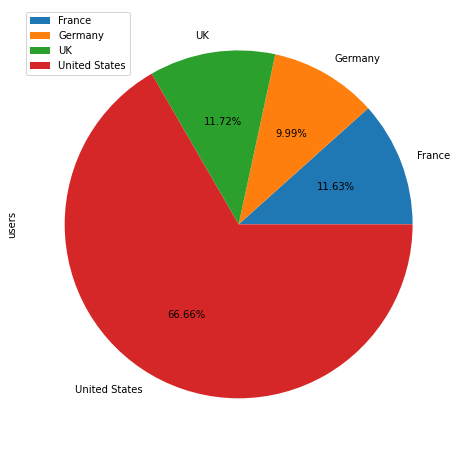

In [41]:
function('region', profiles)

- Более половины клиентов находится в США - 66%, Франция и Англия имеет по 11%, и малая часть находится в Германии.
- Построю круговую диаграмму для более наглядного распределения пользователей приложения. 

In [42]:
region_payer = pd.DataFrame()
region_payer['users'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer['share'] = ((region_payer['users'] / profiles.query('payer == True')['region'].count()) * 100)
region_payer['share'] = region_payer['share'].map('{:,.2f}%'.format)
region_payer.sort_values(by='share', ascending=False)
display(region_payer)

,users,share
region,,
France,663,7.47%
Germany,616,6.94%
UK,700,7.88%
United States,6902,77.72%


- Покупательская способность показывает, что 77% клиентов находятся в США, остальные страны совершили в среднем одинаковое количество покупок.
- Также отражу данные из таблицы на круговой диаграмме

**Расчитаем долю платящих клиентов по каждой стране**

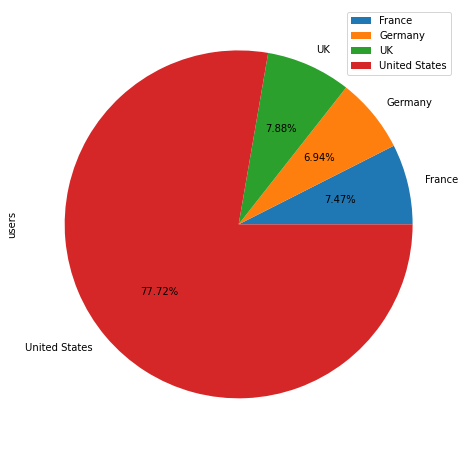

In [43]:
region_payer.plot(kind='pie', y='users', subplots=True, figsize=(8, 8), autopct='%.2f%%')
plt.show()

In [44]:
def function_full(column, df):
    result = pd.DataFrame()
    result['users_all'] = df.groupby(column)['user_id'].count()
    result['all_share'] = (result['users_all'] / df[column].count())
    result['users_payer'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = (result['users_payer'] / result['users_all'])
    return result.sort_values(by='all_share', ascending=False).style.format({'all_share': '{:.2%}', 'payer_share': '{:.2%}'})

In [45]:
function_full('region', profiles)

,users_all,all_share,users_payer,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


**Из таблицы видно,что доля платящих пользователей по регионам распределена таким образом:**

- `США - 6.90%`. - 6902 клиента.

- `Германия - 4.1%`. - 700 клиентов.

- `Англия - 3.98%`. - 663 клиента.

- `Франция - 3.80%`. - 616 клиента.

### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

,users,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


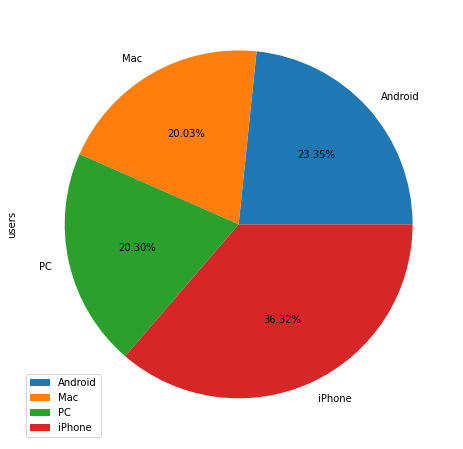

In [46]:
function('device', profiles)

- Заметим более равное распределение пользовательских девайсов:

**Выделяются пользователи `Iphone` (54 479 пользователей) - `36.32%`, следом `23.35%` - пользователи `Андройда` в количестве 35 032 клиента. Замыкают таблицу пользователи `PC`(30 455 пользователя) и `MAC`(30 042 пользователя) - `20.30%` и `20.03%`соответственно.**

- **Узнаем какие устройства предпочитают платящие пользователи.**

In [47]:
payer_device = pd.DataFrame()
payer_device['users'] = profiles.query('payer == True').groupby('device')['user_id'].count()
payer_device['share'] = ((payer_device['users'] / profiles.query('payer == True')['device'].count()) * 100)
payer_device['share'] = payer_device['share'].map('{:,.2f}%'.format)
payer_device

,users,share
device,,
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%
iPhone,3382,38.08%


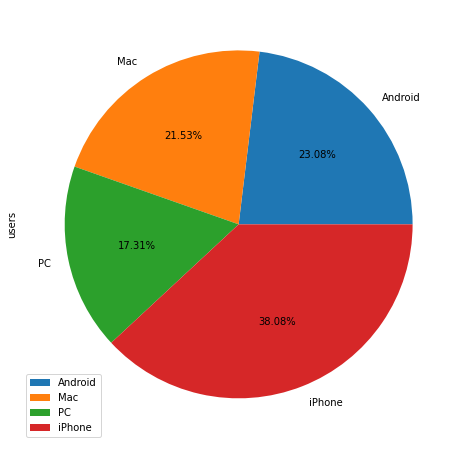

In [48]:
payer_device.plot(kind='pie', y='users', subplots=True, figsize=(8, 8), autopct='%.2f%%')
plt.show()

**- Картинка сильно не изменилась, кроме того, что пользователи системы `MAC` - `21.53%` более платежеспособные пользователей `PC` - `17.31%`, при меньшем общем количестве клиентов.**

In [49]:
function_full('device', profiles)

,users_all,all_share,users_payer,payer_share
device,,,,
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%
Mac,30042,20.03%,1912,6.36%


**Из таблицы видно,что доля девайсов платящих пользователей распределена таким образом:**

- `MAC - 6.36%`. - 1912 клиента.

- `Iphone - 6.21%`. - 3382 клиента.

- `Android - 5.85%`. - 2050 клиента.

- `PC - 5.05%`. - 1537 клиента.

Делаем вывод, что пользовате `MAC` и `Iphone` от общего числа девайсов данной системы самые платежеспособные, `Android` и `PC` замыкают таблицу с близкими показателями.

**Также стоит заметить, что большая часть клиентов и покупок совершались с мобильных систем iPhone и Android.**

### Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

,users,share
channel,,
organic,56439,37.62%
faceboom,29144,19.43%
tiptop,19561,13.04%
opplecreativemedia,8605,5.74%
leapbob,8553,5.70%
wahoonetbanner,8553,5.70%
rocketsuperads,4448,2.97%
mediatornado,4364,2.91%
yrabbit,4312,2.87%


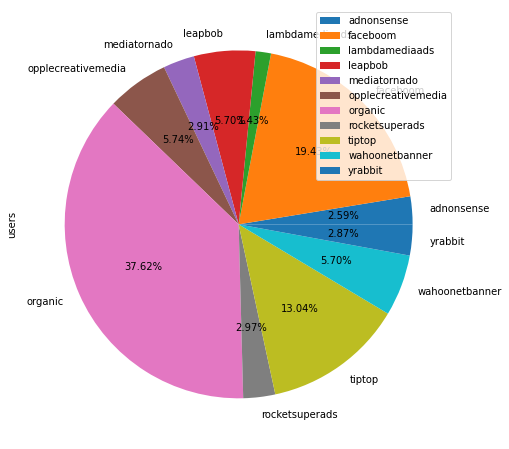

In [50]:
function('channel', profiles)

In [51]:
channels = pd.DataFrame()
channels['users'] = profiles.groupby('channel')['user_id'].count()
channels['share'] = ((channels['users'] / profiles['channel'].count()) * 100)
channels['share'] = channels['share'].map('{:,.2f}%'.format)
channels['payer_users'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channels['payer_share'] = ((channels['payer_users'] / profiles.query('payer == True')['channel'].count()) * 100)
channels['payer_share'] = channels['payer_share'].map('{:,.2f}%'.format)
channels

,users,share,payer_users,payer_share
channel,,,,
adnonsense,3880,2.59%,440,4.95%
faceboom,29144,19.43%,3557,40.05%
lambdamediaads,2149,1.43%,225,2.53%
leapbob,8553,5.70%,262,2.95%
mediatornado,4364,2.91%,156,1.76%
opplecreativemedia,8605,5.74%,233,2.62%
organic,56439,37.62%,1160,13.06%
rocketsuperads,4448,2.97%,352,3.96%
tiptop,19561,13.04%,1878,21.15%


**56 439 пользователя скачали приложение сами(`Organic`), без привлечения (`37.62%`), следом идут 2 крупных канала привлечения `Faceboom` и `Tiptop` - `19.43%` и `13.04%` - соответственно. Остальные 8 каналов привлечения имеют более меньшую долю отклика**

- Построем таблицу и посмотрим процент покупок от общего числа клиентов канала привлечения:

In [52]:
function_full('channel', profiles)

,users_all,all_share,users_payer,payer_share
channel,,,,
organic,56439,37.62%,1160,2.06%
faceboom,29144,19.43%,3557,12.20%
tiptop,19561,13.04%,1878,9.60%
opplecreativemedia,8605,5.74%,233,2.71%
leapbob,8553,5.70%,262,3.06%
wahoonetbanner,8553,5.70%,453,5.30%
rocketsuperads,4448,2.97%,352,7.91%
mediatornado,4364,2.91%,156,3.57%
yrabbit,4312,2.87%,165,3.83%


**`Faceboom` - имеют большую долю платящих для своего канала привлечения, из `29 144` пользователей совершили покупку `3557` человек(`12.20%`), также стоит отметить каналы `Adnonsense и lambdamediaads`, при маленьком количестве пользователей пришедших с этих каналов, `11.34% и 10.47%` совершили покупку, дальше следует `tiptop` со значением `9.60%` при 19 561 привлеченных пользователей, покупку совершили `1 878` пользователей. Особое внимание стоит обратить на `Organic` канал, при скромных `2.06%`, покупку совершили `1 160` человек, что является 3 показателем, и это без вложенных средств на привлечение клиента.**

### Вывод

**Произведя исследовательский анализ данных мы узнали:**

- Основный рынок приложения Procrastinate Pro+ является US (66%)/Доля платящих клиентов также находится в США (77%)


- Больше всего пользователи приложения используют мобильные устройста Iphone и Android, после пользователи Mac и PС. Платящие пользователи распрелелились в таком же рейтинге, как и их общее количество.


- 56 439 пользователя скачали приложение сами(Organic), без привлечения (37.62%), следом идут 2 крупных канала привлечения Faceboom и Tiptop - 19.43% и 13.04% - соответственно. Остальные 8 каналов привлечения имеют более меньшую долю отклика

## **Маркетинг**

### Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

- Общая сумма расходов на маркетинг составила: `105 597`

In [53]:
display(costs.sum())

channel    faceboomfaceboomfaceboomfaceboomfaceboomfacebo...
costs                                               105497.3
dtype: object

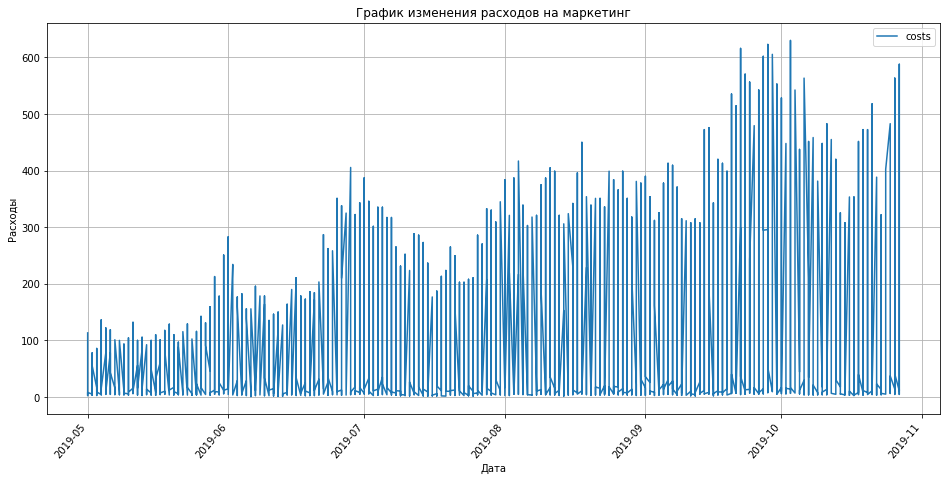

In [54]:
costs.plot(y='costs',
           x='dt',
           figsize=(16, 8),
           grid=True, 
           rot=50                            
) 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

По графику видно, что компания в период исследования постепенно увеличивала расходы на маркетинг, при каждом увеличении заметны спады в расходах, но к концу периода видны выбросы в районе 600.

- Посмотрим как траты распределены по источникам

In [55]:
channel_costs = pd.DataFrame()
channel_costs['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs['share'] = ((channel_costs['costs'] / costs['costs'].sum()) * 100)
channel_costs['share'] = channel_costs['share'].map('{:,.2f}%'.format)
channel_costs

,costs,share
channel,,
adnonsense,3911.25,3.71%
faceboom,32445.60,30.75%
lambdamediaads,1557.60,1.48%
leapbob,1797.60,1.70%
mediatornado,954.48,0.90%
opplecreativemedia,2151.25,2.04%
rocketsuperads,1833.00,1.74%
tiptop,54751.30,51.90%
wahoonetbanner,5151.00,4.88%


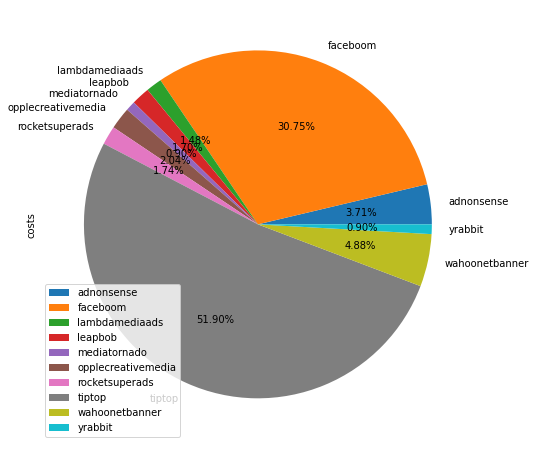

In [56]:
channel_costs.plot(kind='pie', y='costs', subplots=True, figsize=(8, 8), autopct='%.2f%%')
plt.show()

Половина привлечения и самую дорогую часть занимает канал привлечения `Tiptop` - `51.90%` с наивысшими затратами на сумму `54 751.30`
Следом с `30.75%` идет 2й затратный канал `Faceboom`. Дальше идут 8 каналов с малой долей расходов на маркетинг.

        Для расчета CAC нам необходимо:

- Передать функции для создания профилей данные о тратах на рекламу.
- Объединить данные о тратах на рекламу и новых пользователях.
- Вычислить CAC: разделить рекламные расходы на количество новых пользователей.
- Добавить CAC для каждой даты привлечения и источника в профили.

**- Медиана привлечение равна 0.24, а средняя стоимость привлечения одного клиента равна 0.70**

**- Также максимальная стоимость привлечения клиента равна 3.71**

In [59]:
profiles = profiles.query('channel != "organic"')

In [60]:
profiles['acquisition_cost'].describe().round(2)

count    93569.00
mean         1.13
std          0.99
min          0.12
25%          0.26
50%          1.08
75%          1.13
max          3.72
Name: acquisition_cost, dtype: float64

**Построим диаграмму стоимости привлечение одного клиента**

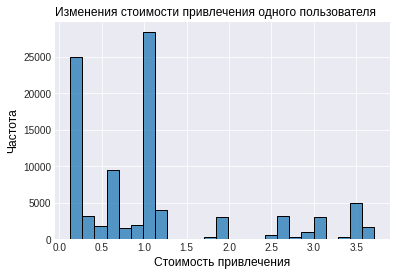

In [61]:
plt.style.use('seaborn-darkgrid')
sns.histplot(data=profiles, x='acquisition_cost', bins=25)
plt.title('Изменения стоимости привлечения одного пользователя', loc='left', fontsize=12,fontweight=3, color='black')
plt.xlabel('Стоимость привлечения', fontsize=12,fontweight=0, color='black')
plt.ylabel('Частота', fontsize=12,fontweight=0, color='black')
plt.show()

**- Видно много значений в области нуля. Скорее всего эти привлечения произошли натурально, из канала `Organic`.**

- Построим таблицу САС для каждого источника. Также выведу максимальную стоимость привлечения клиента, чтобы проверить возможный выброс

In [62]:
cac = pd.DataFrame()
cac['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac['acquisition_cost_mean'] = cac['acquisition_cost_mean'].map('{:,.2f}'.format)
cac['acquisition_cost_max'] = profiles.groupby('channel')['acquisition_cost'].max()
cac['acquisition_cost_max'] = cac['acquisition_cost_max'].map('{:,.2f}'.format)
cac

,acquisition_cost_mean,acquisition_cost_max
channel,,
adnonsense,1.01,1.31
faceboom,1.11,1.18
lambdamediaads,0.72,0.91
leapbob,0.21,0.23
mediatornado,0.22,0.27
opplecreativemedia,0.25,0.28
rocketsuperads,0.41,0.60
tiptop,2.80,3.72
wahoonetbanner,0.60,0.66


**Видим, что самая высокая стоимость привлечения пользователя у канала Tiptop - 2.80, в других каналах значения в 2 раза меньше. Выбросов в столбце максимальной стоимости привлечение пользователя не обнаружено.**

### Вывод

Из проведенного анализа сделаем данные выводы:

- Чуть больше половины затрат `105497.3` приходится на канал `Tiptop(51.9%)`, за ним идет источние `Faceboom` с `30.75%`.э

- Построив график изменения расходов на маркетинг мы заметили, что с `мая` при средних затратах в `100`, компания `Procrastinate Pro+` заметно увеличивала расходы на маркетинг, к `октябрю` затраты достигали отметки в `600` по одному из крупных каналов, в среднем же 8 каналов обходятся Procrastinate Pro+ достаточно дешево.

- `Средняя стоимость` привлечения одного клиента находится на уровне `0.24`.

- `Стоимость привлечения одного клиента` каннала `TipTop` находится на уровне `2.80`, при максимальной в `3.72`

- Остальные же каналы привлечения имеют стоимость в диапазоне `(0.21 - 1.01)`

## **Оценка окупаемости рекламы**

**- Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определим самостоятельно.**

### Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Построим и изучим графики конверсии и удержания.

- Воспользуемся функциями для расчета LTV и ROI и их визуалициями.

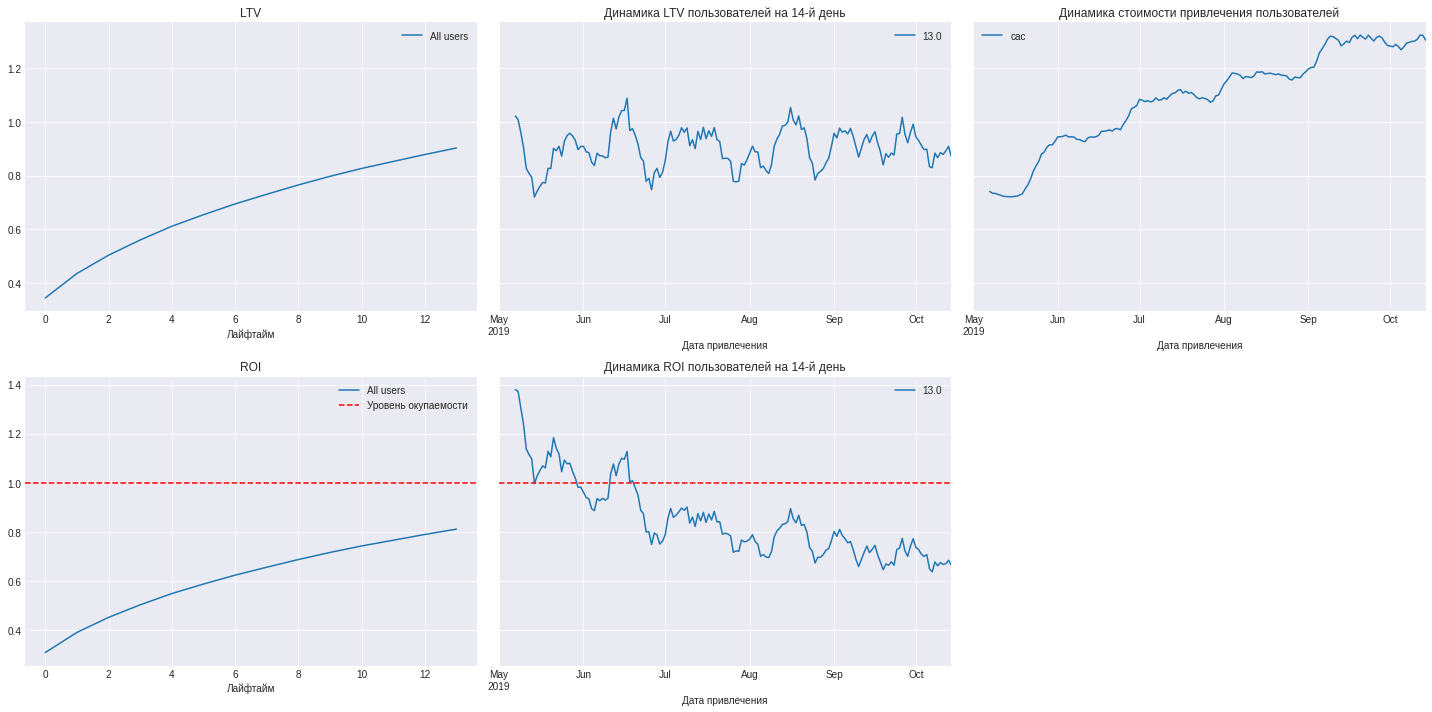

In [63]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- График LTV в норме, видны взлеты и падения, каждый последующий спад не падает ниже последнего, это может быть связано с сезонностью входа клиентов.


- Показатели СAC имеют анамольно высокие скачки вверх, ниже мы провериим с чем это связано.


- ROI в отметке 80%, окупаемость низкая, также за последние 2 недели видно, что окупаемость до июля была положительной, после все показатели стали отрицательными.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Построим и изучим графики конверсии и удержания.

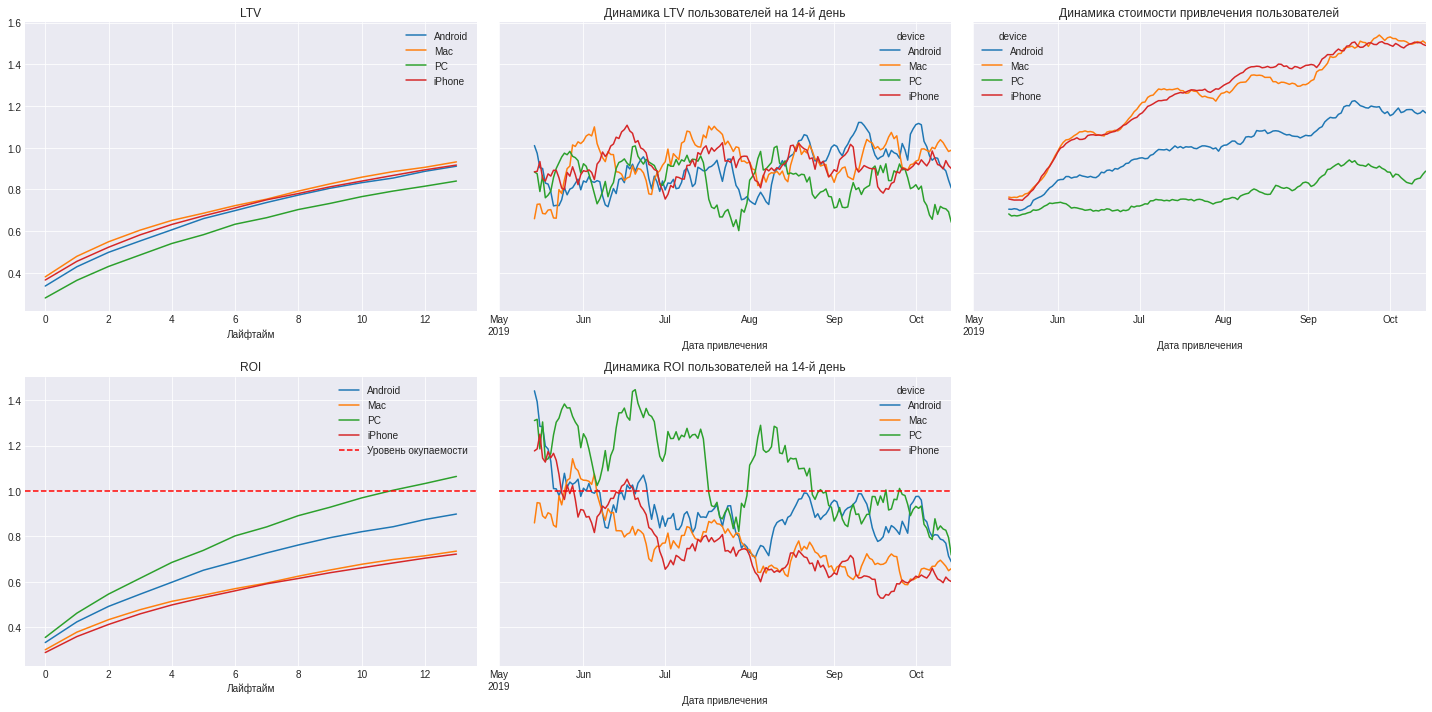

In [64]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['device'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 14) 

- До июня все пользователи всех устройсв окупались, после заметен спад.

- ROI пользователей PC показывает самую лучшую окупаемость, при меньшей популярности к другим устройствам.

- LTV присуща сеззонность, видны как подъемы, так и спады.

- Самая высокая стоимость привлечения у пользователей MAC и Iphone, окупаемость на низком уровне.

- **Построим графики удержания пользователей**

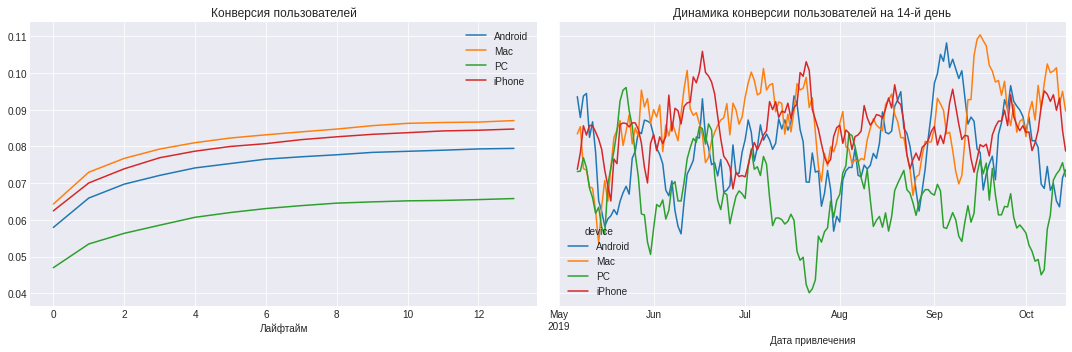

In [65]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия показывает, что конверсия пользователей Mac & Iphone & Android на достаточно высоком уровне.

- Конверсия пользователей PC ниже, и имеет более сильные спады, чем его аналоги.

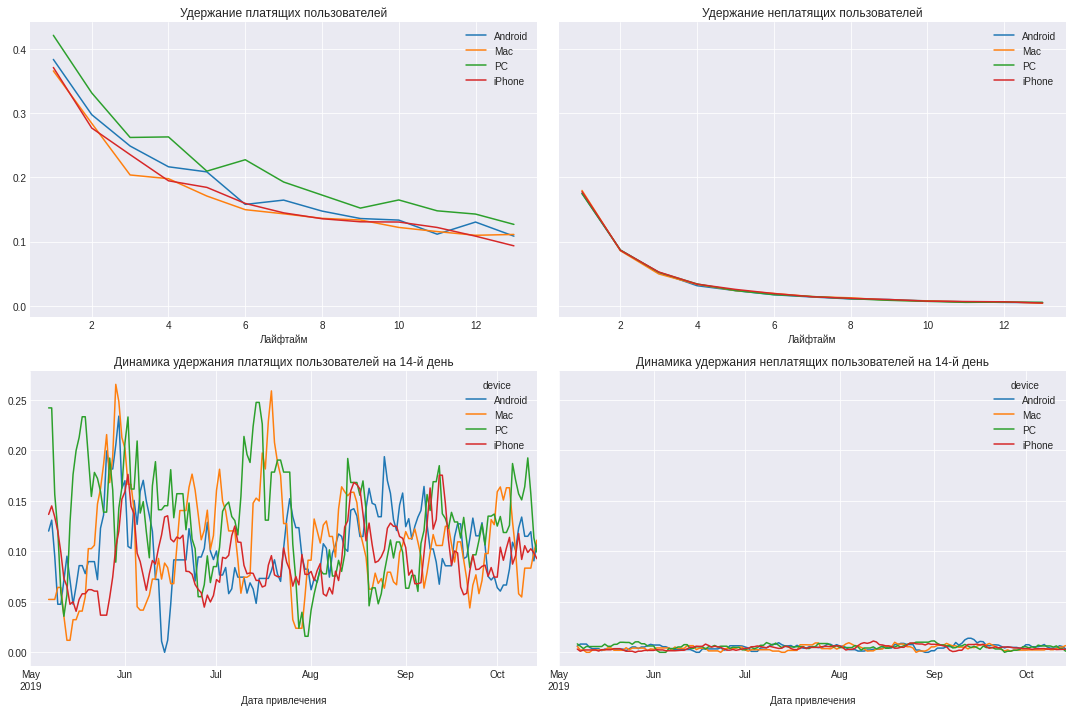

In [66]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['device'])

plot_retention(retention_grouped, retention_history, horizon_days) 

- Не платящие пользователи очевидно хуже удерживаются, чем платящие.

- Лучше всего удерживаются пользователи `PC`, хуже - `Iphone` и `Mac`.


### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Построим и изучим графики конверсии и удержания.

Проведем анализ по странам и проверим их окупаемость.

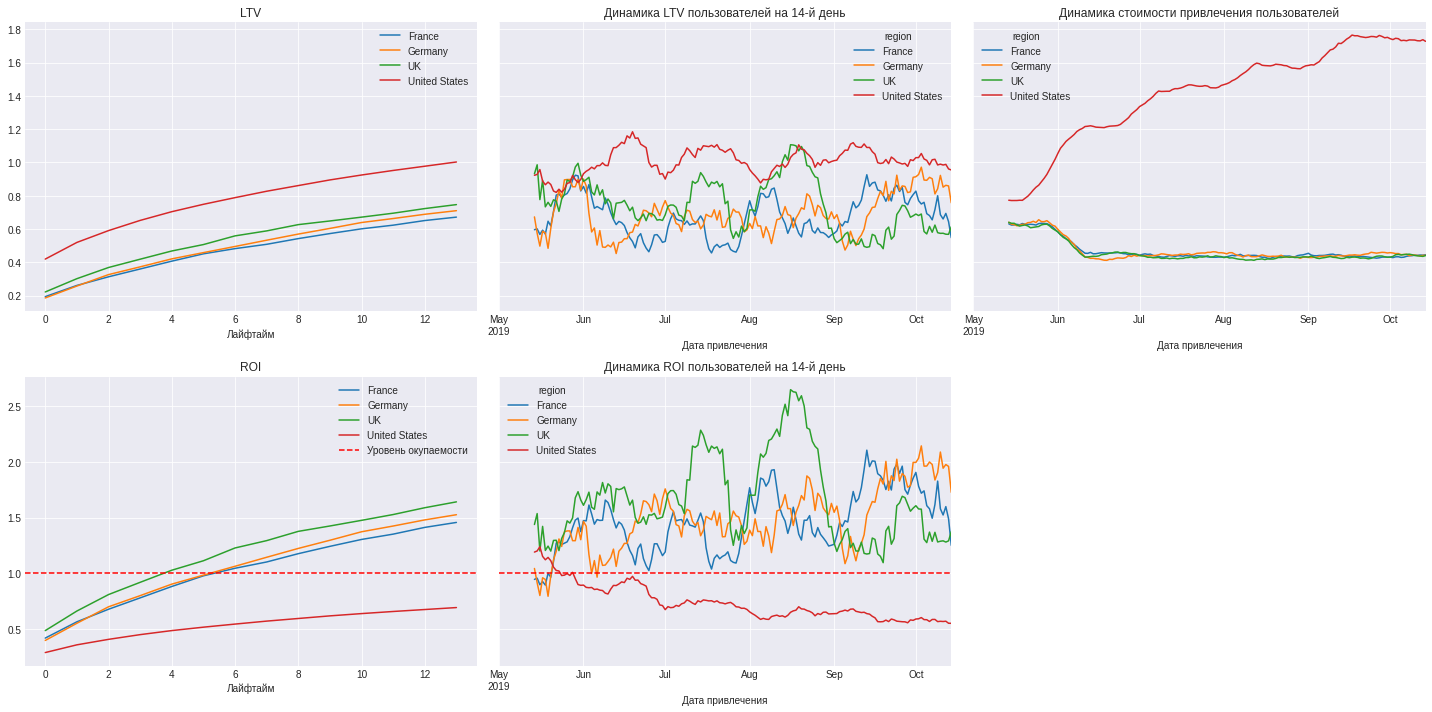

In [67]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['region'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Первым стоит отметить, что стоимость пользователя `France`, `Germany` и `UK` в начале июня начала падать, а САС очень стремительно пошла вверх.

- Также, заметно, что ROI 3х стран при падении стоимости начали окупать себя, лидер - `UK`, дальше Germany, а `US` так и не окупила из-за высокой стоимости, при самом большом количестве пользователей из этой страны.

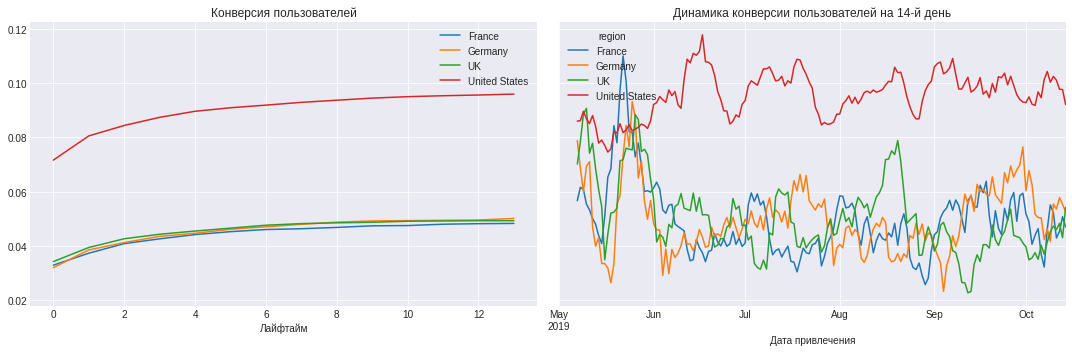

In [68]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Конверсия пользователей `US` в 2 раза больше пользователей других стран, так же в июне виден высокий скачок конверсии пользователей `Germany`, `UK`, `France`, но после он идет на спад

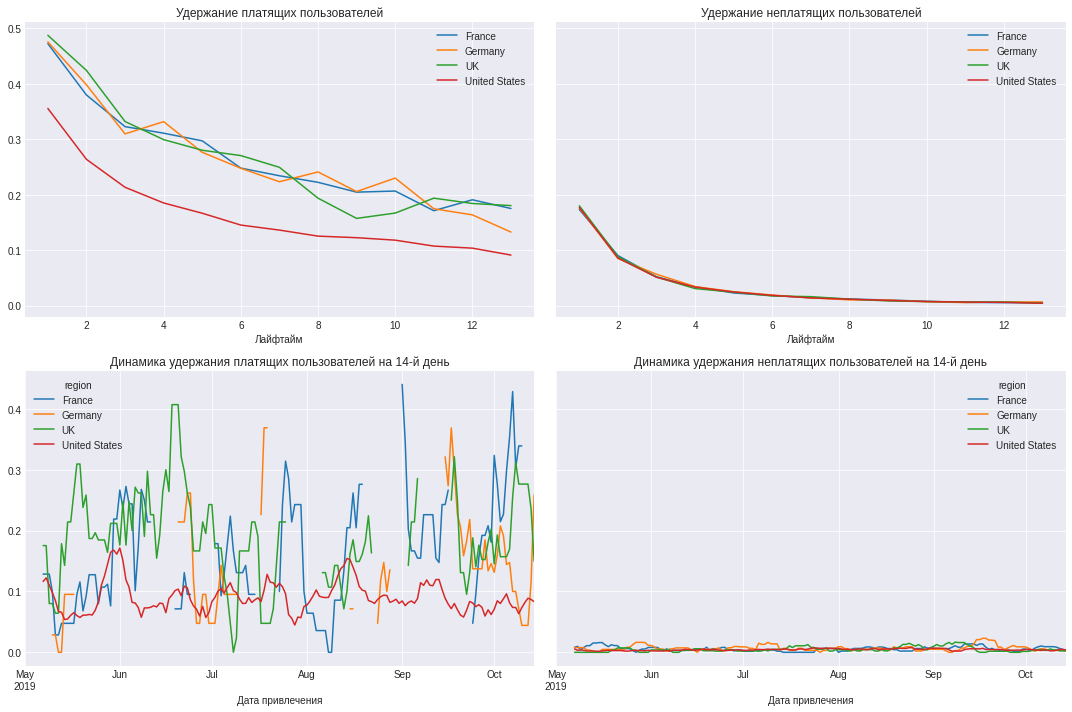

In [69]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['region'])

plot_retention(retention_grouped, retention_history, horizon_days) 

- Неплатящие пользователи одинаково плохо удерживаются, вне зависимости от их численности или место нахождения.

- Платящие пользователи `US` очень плохо удерживаются, при самой большей аудитории

- **Обратим внимание на рынок US.**

In [70]:
usa = (profiles
      .query('region == "United States"')
)
usa

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
4,31989216,2019-10-02 00:07:44,yrabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
8,58263264,2019-05-11 19:18:43,faceboom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,mediatornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,tiptop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
150001,999949280903,2019-08-12 06:47:27,faceboom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:02,tiptop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:06,tiptop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


In [71]:
function_full('channel', usa)

,users_all,all_share,users_payer,payer_share
channel,,,,
faceboom,29144,47.14%,3557,12.20%
tiptop,19561,31.64%,1878,9.60%
rocketsuperads,4448,7.19%,352,7.91%
mediatornado,4364,7.06%,156,3.57%
yrabbit,4312,6.97%,165,3.83%


,users,share
channel,,
faceboom,29144,47.14%
tiptop,19561,31.64%
rocketsuperads,4448,7.19%
mediatornado,4364,7.06%
yrabbit,4312,6.97%


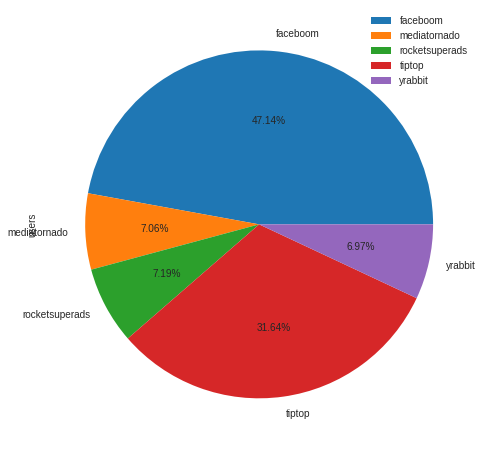

In [72]:
function('channel', usa)

- Почти половина пользователей `US` пришла из `Faceboom`(100% трафика из этого канала) при стоимости 1.1, а также 100% трафика в канале `tiptop` пришлось на пользователей US при самой большей стоимости в 2.8

- Также заметим, очень малую долю клиентов совершивших покупку, из-за высокой стоимости клиента, а главное ее малой платежеспобности мы можем сказать, что `самая главная проблема заключается` в каналах привлечения направленные на основной развитый и богатый рынок - `US`.

###  Проанализируем окупаемость рекламы с разбивкой по каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI. Постройте и изучите графики конверсии и удержания.

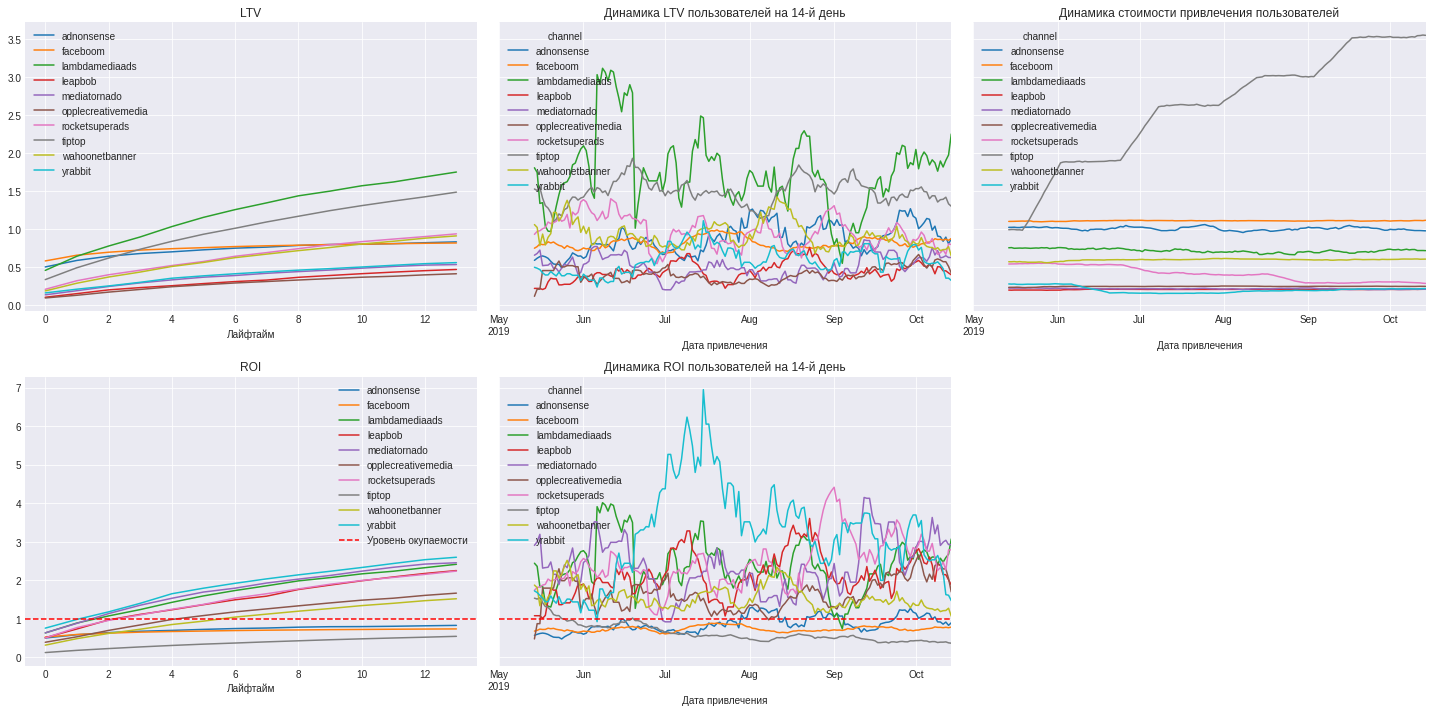

In [73]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- Самый затратный канал привлечения оказался `Tiptop` при привлеченных (`19 561 пользователях`), при этом его окупаемость находится на ужасном уровне, что говорит о самом проблемном месте в нашем исследовании.

- Также не окупилась реклама канала `Faceboom` с 1й по численности привлечения (`29 144`) и `Adnonsense` c (`3 880`).

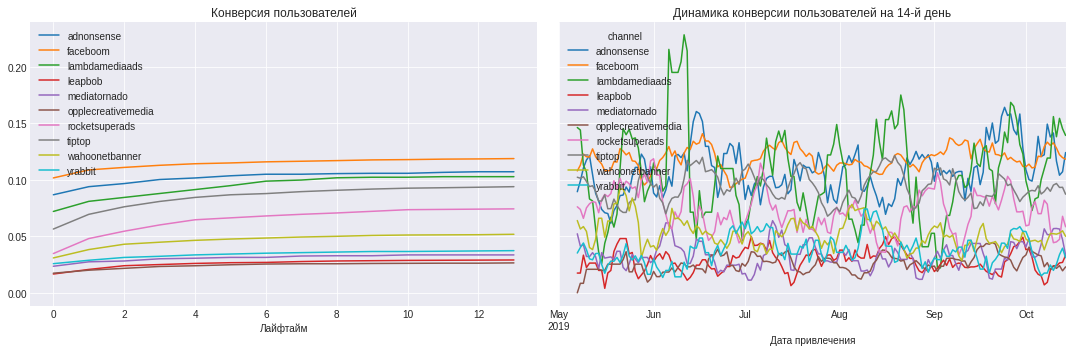

In [74]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Видим низкую конверию канала `Leapbob`, `opplecreativemedia`

- Лучший показатель у канала привлечения `Faceboom`

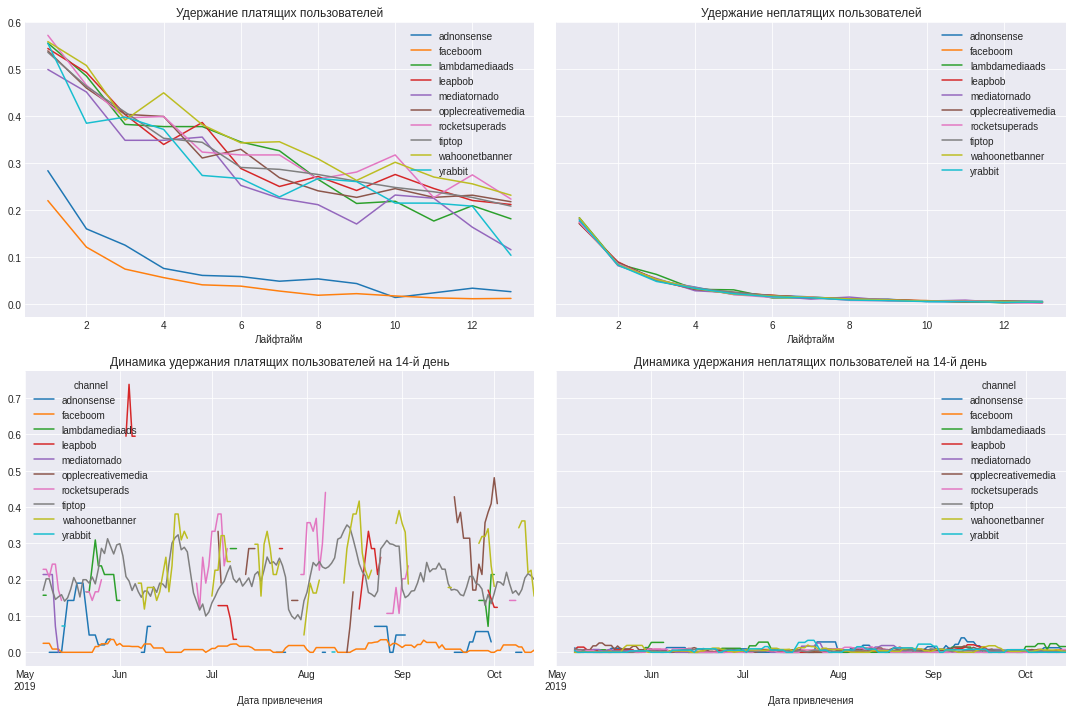

In [75]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = ['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

- Также и по каналам заметно, что динамика удержания неплатящих пользователей одинакова ужасна

- Пользователи `Faceboom` при своих затратах и Adnonsense имеют худшую динамику удержания платящих пользователей.

**Проблема Окупаемости пользователей связана:**

- Не окупилась реклама пользователей `US`, также удержание данных пользователей на очень низком уровне.

- Пользователи `Mac и Iphone` имееют низкую окупаемость и удержание, возможно связана с технической проблемой пользователей Apple.

- Неоправдана стоимость привлечения одного пользователя из каналов: `Tiptop`, `Faceboom` и `Adnonsense`, реклама из-за слишкой высокой цены не окупилась совсем.

## Вывод

- Самая проблемная зона приложения `Procrastinate Pro+`, то что 3 канала привлечения: `Tiptop(2.80)`, `Faceboom(1.11)`, `Adnonsense(1.01)` с самой большой базой привлечения и самой высокой САС так и не окупили свою рекламу.

- Также необходимо обратить внимание на пользователей системы `Apple`, `при растущем CAC` мы видим очень `низкое удержание пользователей`.

- Пользователи `США (100 002 клиента)` и это целых `66.66%` от общего числа пользователей имеет самую низкую окупаемость, при самой высокой стоимости привлечения пользователя из этой страны, необходимо пересмотреть рынок US, и создать новую стратегию привлечения пользователей.

- Стоит перенаправить средства и вложить их в канал привлечения: `Yrabbit(0.22)`, `Mediatornado(0.22)`, `Lambdamediaads(0.72)` - при достаточно низкой стоимости привлечения одного клиента, каналы показали очень высокую окупаемость.

- Пользователи `Франции`, `Англии` и `Германии` при достаточно низкой численности, имеют достаточно высокую окупаемость, при более меньших затратах. 

- Возможно, стоит обратить внимание на новые рынки Европы, при более низком количестве потенциальных клиентов, можно допустить, что они будут прибыльны и уже после более устойчивой позиции на рынке приложений смотреть в сторону US. 